## OpenAI gym / Farama Foundation Gymnasium

[Gym](https://gym.openai.com) — это набор инструментов для разработки и сравнения алгоритмов обучения с подкреплением, который также включает в себя большой [набор окружений](https://gym.openai.com/envs/).

[Gymnasium](https://gymnasium.farama.org/) — актуальный форк Gym'а. Имеет смысл по возможности использовать его. Но, т.к. большинство гайдов написаны под старую (pre- 0.21) версию Gym'а, то будьте готовы к [некоторым правкам кода](https://gymnasium.farama.org/content/migration-guide/).

Импортируем необходимые библиотеки и настраиваем визуализацию:

In [1]:
import glob
import io
import base64
from IPython import display as ipythondisplay
from IPython.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


def show_video(folder="./video"):
    mp4list = glob.glob(folder + '/*.mp4')
    if len(mp4list) > 0:
        mp4 = sorted(mp4list, key=lambda x: x[-15:], reverse=True)[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

In [2]:
import gymnasium as gym

# Создаем окружение
env = gym.make("MountainCar-v0")

# Инициализируем окружение
state, info = env.reset()
print(f"state: {state}")

# Выполняем действие в среде
next_state, r, terminated, truncated, info = env.step(0)
print(
    f"next_state: {next_state} , r: {r}, "
    f"terminated: {terminated}, truncated: {truncated}, "
    f"info: {info}"
)

# Закрываем окружение
env.close()

state: [-0.5788119  0.       ]
next_state: [-0.57939965 -0.00058779] , r: -1.0, terminated: False, truncated: False, info: {}


### Основные методы окружения:

* ``reset()`` $-$ инициализация окружения, возвращает первое наблюдение (состояние) и доп информацию.  
* ``step(a)`` $-$ выполнить в среде действие $\mathbf{a}$ и получить кортеж: $\mathbf{\langle s_{t+1}, r_t, terminated, truncated, info \rangle}$, где $\mathbf{s_{t+1}}$ - следующее состояние, $\mathbf{r_t}$ - вознаграждение, $\mathbf{terminated}$ - флаг заверешния эпизода, $\mathbf{truncated}$ — флаг завершения эпизода по step-лимиту, $\mathbf{info}$ - дополнительная информация

### Дополнительные методы:
* ``render()`` $-$ визуализация текущего состояния среды
* ``close()`` $-$ закрывает окружение


### Свойства среды:
* ``env.observation_space`` $-$ информация о пространстве состояний
* ``env.action_space`` $-$ информация о пространстве действий


In [3]:
print(f"env.observation_space: {env.observation_space}")
print(f"env.action_space: {env.action_space}")

env.observation_space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
env.action_space: Discrete(3)


[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


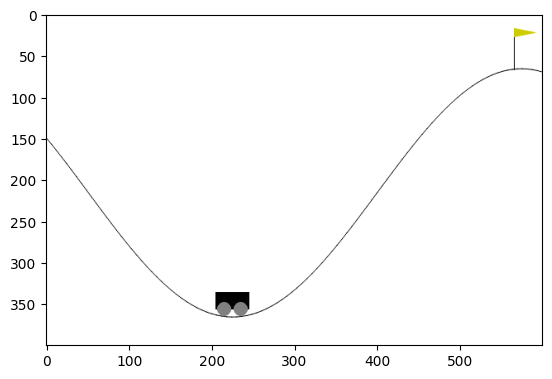

In [4]:
# Отрисовка
env = gym.make("MountainCar-v0", render_mode="rgb_array")
env.reset()
print(env.render())
plt.imshow(env.render())
None

### Среда ``MountainCar-v0``

Информацию о любой среде можно найти в [исходниках](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/mountain_car.py) или на [сайте](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/). О ``MountainCar-v0`` мы можем узнать следующее:

#### Задание:
Автомобиль едет по одномерному треку между двумя холмами. Цель состоит в том, чтобы заехать на правый холм; однако двигатель машины недостаточно мощный, чтобы взобраться на холм за один проход. Следовательно, единственный способ добиться успеха $-$ это двигаться вперед и назад, чтобы набрать обороты.

#### Пространство состояний Box(2):



Num | Observation  | Min  | Max  
----|--------------|------|----   
0   | position     | -1.2 | 0.6
1   | velocity     | -0.07| 0.07


#### Пространство действий Discrete(3):



Num | Action|
----|-------------|
0   | push left   |
1   | no push     |
2   | push right  |

* Вознаграждения: -1 за каждый шаг, пока не достигнута цель

* Начальное состояние: Случайная позиция от -0.6 до -0.4 с нулевой скоростью.

### Пример со случайной стратегией:

Для выбора действия используется ``env.action_space.sample()``

In [5]:
from gymnasium.wrappers import RecordVideo

# создаем окружение с ограничением на число шагов в среде
env = gym.make("MountainCar-v0", render_mode="rgb_array", max_episode_steps=250)
# добавляем визуализацию
env = RecordVideo(env, "./video")

# проводим инициализацию и запоминаем начальное состояние
s, _ = env.reset()
done = False
max_steps = 1000
steps = 0

while not done and steps <= max_steps:
    steps += 1

    # выполняем действие, получаем s, r, done, info
    s, r, done, _, _ = env.step(env.action_space.sample())

env.close()

In [6]:
from IPython.display import Video

Video('video/rl-video-episode-0.mp4', embed=True)

### Задание 1:
В среде MountainCar-v0 мы хотим, чтобы машина достигла флага. Давайте решим эту задачу, не используя обучение с подкреплением. Модифицируйте код функции ```act``` ниже для выполнения этого задания. Функция получает на вход состояние среды и должна вернуть действие.

In [7]:
def act(s):
    # возможные действий
    left, stop, right = 0, 1, 2
    # позиция и скорость
    position, velocity = s

    # если скорость положительная - продолжаем ехать вправо
    if velocity > 0:
        action = right
    # иначе - разгоняемся в другую сторону
    else:
        action = left

    return action

In [8]:
env = gym.make("MountainCar-v0", render_mode="rgb_array", max_episode_steps=250)
# добавляем визуализацию
env = RecordVideo(env, "./video")

# проводим инициализацию и запоминаем начальное состояние
s, _ = env.reset()

while True:
    # выполняем действие, получаем s, r, done, info
    s, r, terminated, truncated, _ = env.step(act(s))
    if terminated or truncated:
        break

if s[0] > 0.47:
    print("Принято!")
else:
    print("Исправьте функцию выбора действия!")


env.close()
show_video()

Принято!


### Пример случайная стратегия в игре FrozenLake

In [9]:
env = gym.make("FrozenLake-v1", max_episode_steps=500, render_mode="rgb_array")
env = RecordVideo(env, "./video")

s, _ = env.reset()
done = False

while not done:
    s, r, done, *_ = env.step(env.action_space.sample())


env.close()
show_video()